In [16]:
import torch
import torch.distributions as D
import torch.distributions.transforms as T
import matplotlib.pyplot as plt

In [28]:
import torch
import torch.nn.functional as F
from torch.distributions import constraints, Distribution, TransformedDistribution, MultivariateNormal
from torch.distributions.transforms import Transform

class LinearTransform(Transform):
    """
    A custom transform that applies a linear transformation y = Ax + b,
    where 'A' is a full-rank matrix.

    Args:
        loc (torch.Tensor): The translation vector 'b'. Shape: (out_features,)
        scale_matrix (torch.Tensor): The transformation matrix 'A'. Shape: (out_features, in_features)
    """
    domain = constraints.real_vector
    codomain = constraints.real_vector
    bijective = True

    def __init__(self, loc: torch.Tensor, scale_matrix: torch.Tensor, cache_size=0):
        super().__init__(cache_size=cache_size)
        self.loc = loc
        self.scale_matrix = scale_matrix
        
        # For the inverse, we pre-compute the inverse of A.
        # For numerical stability, you might solve a linear system instead,
        # but for a reusable transform, pre-computing is often fine.
        self.inv_scale_matrix = torch.linalg.inv(self.scale_matrix)

    def __eq__(self, other):
        return (isinstance(other, LinearTransform) and
                torch.allclose(self.loc, other.loc) and
                torch.allclose(self.scale_matrix, other.scale_matrix))

    @property
    def sign(self) -> float:
        return torch.sign(torch.linalg.det(self.scale_matrix)).item()

    def _call(self, x: torch.Tensor) -> torch.Tensor:
        """Computes y = Ax + b"""
        # F.linear(x, W) computes xW^T. So we pass A.T to get x(A.T)^T = xA.
        # But wait, we want Ax. If x is a row vector (batch, features), then we want xA^T.
        # Let's use matmul for clarity: y = x @ A^T + b
        return torch.matmul(x, self.scale_matrix.T) + self.loc

    def _inverse(self, y: torch.Tensor) -> torch.Tensor:
        """Computes x = A^{-1}(y - b)"""
        # (y - b) @ (A^{-1})^T
        return torch.matmul(y - self.loc, self.inv_scale_matrix.T)

    def log_abs_det_jacobian(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """
        The Jacobian of the transformation y = Ax + b is simply A.
        This method returns log|det(A)|.
        """
        # torch.linalg.slogdet returns (sign, logabsdet). We just need the logabsdet.
        _, log_abs_det = torch.linalg.slogdet(self.scale_matrix)
        
        # Expand to the batch shape of the input x
        batch_shape = x.shape[:-1]
        return log_abs_det.expand(batch_shape)

In [107]:
mu = torch.randn(2)
cov_factor = torch.randn(2,2)
cov = cov_factor @ cov_factor.t()
dist = D.MultivariateNormal(torch.zeros(2), covariance_matrix=torch.eye(2))

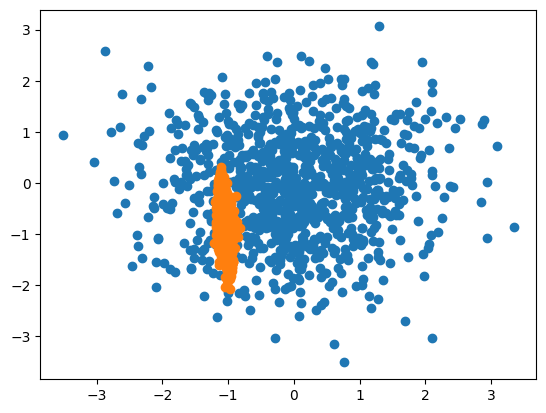

In [108]:
samples = dist.sample([1000])
plt.scatter(samples[:,0], samples[:,1])

lin_transform1 = LinearTransform(torch.randn(2), torch.randn(2,2))
lin_transform2 = LinearTransform(torch.randn(2), torch.randn(2,2))

affine = T.AffineTransform(torch.randn(1), torch.randn(1))
flow = D.TransformedDistribution(dist, [lin_transform1, T.SigmoidTransform(), lin_transform2])
samples = flow.sample([1000])
plt.scatter(samples[:,0], samples[:,1])

In [25]:
T.AffineTransform?

Init signature: T.AffineTransform(loc, scale, event_dim=0, cache_size=0)
Docstring:     
Transform via the pointwise affine mapping :math:`y = \text{loc} + \text{scale} \times x`.

Args:
    loc (Tensor or float): Location parameter.
    scale (Tensor or float): Scale parameter.
    event_dim (int): Optional size of `event_shape`. This should be zero
        for univariate random variables, 1 for distributions over vectors,
        2 for distributions over matrices, etc.
File:           /WorkSpace-2/csamplawski/src/BayesAdapt/.venv/lib/python3.12/site-packages/torch/distributions/transforms.py
Type:           type
Subclasses:     